In [1]:
%matplotlib inline
import re
import json
import time
import torch
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
from utils import set_seed, smoothen_list, make_confusion_matrix
from datasets import load_dataset, concatenate_datasets, DatasetDict
from evaluate import load
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler, pipeline, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from huggingface_hub import login
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from deepspeed.profiling.flops_profiler import FlopsProfiler

logs_dict = {}
logs_dict["seed"] = set_seed(42)

[2024-04-23 13:51:42,907] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
All random seeds set to 42.


In [2]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

In [3]:
# model_version: 2 values ("base", "large")
model_version = "base"
# lora_rank:    10 values [1, ..., 512]
lora_rank = 16
# lora_bias:     3 values ["all", "none", "lora_only"]
lora_bias = "all"
# lora_dropout:  5 values [0, 0.1, 0.2, 0.3, 0.4]
lora_dropout = 0.2
# datasets:      3 values [1%, 10%, 100%]
split = "dev"

In [4]:
def build_model_and_tokenizer(label_names, model_version, lora_rank, lora_bias, lora_dropout, split):
    id2label = {str(i): label for i, label in enumerate(label_names)}
    label2id = {v: k for k, v in id2label.items()}
    model_version = "large" # "base" or "large"
    model_id = f"FacebookAI/roberta-{model_version}"
    logs_dict["model_id"] = model_id
    model = AutoModelForTokenClassification.from_pretrained(
        model_id,
        id2label=id2label,
        label2id=label2id,
        device_map="auto",
        load_in_8bit=True
    )
    LoRA_params_dict = {
        "r": lora_rank,
        "target_modules": ["query", "key", "value", "query_proj", "key_proj", "value_proj"],
        "bias": lora_bias,
        "use_rslora": True,
        "task_type": TaskType.TOKEN_CLS,
        "lora_dropout": lora_dropout
    }
    logs_dict["LoRA_params_dict"] = LoRA_params_dict
    config = LoraConfig(
        # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
        # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
        # https://arxiv.org/abs/2312.03732, 
        r = LoRA_params_dict["r"],
        target_modules=LoRA_params_dict["target_modules"],
        bias=LoRA_params_dict["bias"],
        use_rslora=LoRA_params_dict["use_rslora"],
        task_type=LoRA_params_dict["task_type"],
        lora_dropout=LoRA_params_dict["lora_dropout"]
    )
    logs_dict["LoraConfig"] = str(config)
    print(f"LoRA config:\n{config}\n")
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, config)
    print(f"base_model type:\n{type(model)}")
    print(f"\nadapter_model type:\n{type(model)}")
    trainable_params, all_params = model.get_nb_trainable_parameters()
    trainable_fraction = round(trainable_params/all_params, 5)
    logs_dict["LoRA_model_trainable_params"] = trainable_params
    logs_dict["LoRA_model_all_params"] = all_params
    logs_dict["LoRA_model_trainable_fraction"] = trainable_fraction
    print(f"\ntrainable parameters:\n{trainable_params}")
    print(f"\nall parameters:\n{all_params}")
    print(f"\ntrainable fraction:\n{trainable_fraction}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
    logs_dict["tokenizer"] = model_id
    print(f"\ntokenizer is fast: {tokenizer.is_fast}")
    spec = f"split={split}"
    spec += f"__r={LoRA_params_dict['r']}"
    spec += f"__bias={LoRA_params_dict['bias']}"
    spec += f"__loradroput=0point{str(LoRA_params_dict['lora_dropout'])[2:]}"
    model_folder = re.sub("/", "-", model_id)
    output_dir = f"ner_logs/{model_folder}/{spec}"
    return model, tokenizer, output_dir

model, tokenizer, output_dir = build_model_and_tokenizer(
    label_names=label_names,
    model_version=model_version,
    lora_rank=lora_rank,
    lora_bias=lora_bias,
    lora_dropout=lora_dropout,
    split=split
)
type(model), tokenizer, output_dir

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA config:
LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=16, target_modules={'value', 'key', 'value_proj', 'query_proj', 'query', 'key_proj'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

base_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

adapter_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

trainable parameters:
2639881

all parameters:
356687890

trainable fraction:
0.0074

tokenizer is fast: True


(peft.peft_model.PeftModelForTokenClassification,
 RobertaTokenizerFast(name_or_path='FacebookAI/roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
 	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
 },
 'ner_logs/FacebookAI-roberta-lar

In [5]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # special token
            new_labels.append(-100)
        else:
            # same word as previous token
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs
    
def build_dataloaders(raw_datasets, split):
    fewnerd_all_processed = (
        concatenate_datasets([raw_datasets["train"], raw_datasets["validation"], raw_datasets["test"]])
        .filter(lambda example: len(example["tokens"])<=50)
        .map(
            tokenize_and_align_labels,
            batched=True,
            remove_columns=raw_datasets["train"].column_names
        )
    )
    #
    trainvalid_test_splits = fewnerd_all_processed.train_test_split(test_size=0.15)
    test_split_100 = trainvalid_test_splits["test"]
    test_split_10 = test_split_100.train_test_split(test_size = 0.1)["test"]
    test_split_1 = test_split_100.train_test_split(test_size = 0.01)["test"]
    trainvalid_split = trainvalid_test_splits["train"]
    train_valid_split = trainvalid_split.train_test_split(test_size=0.15)
    valid_split_100 = train_valid_split["test"]
    valid_split_10 = valid_split_100.train_test_split(test_size = 0.1)["test"]
    valid_split_1 = valid_split_100.train_test_split(test_size = 0.01)["test"]
    train_split_100 = train_valid_split["train"]
    train_split_10 = train_split_100.train_test_split(test_size = 0.1)["test"]
    train_split_1 = train_split_100.train_test_split(test_size = 0.01)["test"]
    dev_train_split = train_split_100.train_test_split(test_size = 120)["test"]
    dev_valid_split = valid_split_100.train_test_split(test_size = 32)["test"]
    dev_test_split = test_split_100.train_test_split(test_size = 8)["test"]
    fewnerd_dsd = DatasetDict({
        "train_100": train_split_100,
        "train_10": train_split_10,
        "train_1": train_split_1,
        "valid_100": valid_split_100,
        "valid_10": valid_split_10,
        "valid_1": valid_split_1,
        "test_100": test_split_100,
        "test_10": test_split_10,
        "test_1": test_split_1,
        "train_dev": dev_train_split,
        "valid_dev": dev_valid_split,
        "test_dev": dev_test_split
    })
    train_split = f"train_{split}"
    valid_split = f"valid_{split}"
    test_split = f"test_{split}"
    #
    batchsize_dict = {
        # batch size rules: (i) as large as possible, (ii) 1000 steps per epoch, (iii) 32 max
        "100": 32,
        "10": 8,
        "1": 1,
        "dev": 2
    }
    batch_size = batchsize_dict[split]
    logs_dict["batch_size"] = batch_size
    #
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    train_dataloader = DataLoader(
        fewnerd_dsd[train_split],
        shuffle=True,
        collate_fn=data_collator,
        batch_size=batch_size
    )
    valid_dataloader = DataLoader(fewnerd_dsd[valid_split], collate_fn=data_collator, batch_size=batch_size)
    return train_dataloader, valid_dataloader, batch_size

train_dataloader, valid_dataloader, batch_size = build_dataloaders(
    raw_datasets=raw_datasets,
    split=split
)
train_dataloader, valid_dataloader, batch_size

(<torch.utils.data.dataloader.DataLoader at 0x7796695cd060>,
 2)

In [6]:
def flatten_list_of_lists(list_of_lists):
    flattened_list = []
    for list_i in list_of_lists:
        list_i = list_i.tolist() # handle tensors in case list_of_lists is a list of tensors
        list_i = list(itertools.chain.from_iterable(list_i)) # flatten list_i using the standard library
        flattened_list += list_i
    return flattened_list

def compute_metrics(y_true, y_pred, average_type):
    metrics_dict = classification_report(y_true, y_pred, digits=6, output_dict=True, zero_division=0.0)
    accuracy = metrics_dict["accuracy"]
    avg_dict = metrics_dict[average_type]
    avg_dict["accuracy"] = accuracy
    # https://stackoverflow.com/questions/52139110/how-to-change-the-order-of-keys-in-a-python-3-5-dictionary-using-another-list-a
    avg_dict_order = {k : avg_dict[k] for k in ["accuracy", "precision", "recall", "f1-score", "support"]}
    avg_dict_order["support"] = round(avg_dict_order["support"])
    metrics = [f"{key}: {avg_dict_order[key]}" for key in avg_dict_order.keys()]
    return metrics

def train_model(model, train_dataloader, valid_dataloader, batch_size):
    optimizer = AdamW(model.parameters(), lr=1e-3) # 5e-4 works
    accelerator = Accelerator()
    model, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(
        model,
        optimizer,
        train_dataloader,
        valid_dataloader
    )
    num_train_epochs = 3
    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_train_epochs * num_update_steps_per_epoch
    logs_dict["num_training_steps"] = num_training_steps
    num_warmup_steps = min(500, round(0.15 * num_update_steps_per_epoch)) # 500 or 15% of one epoch, whichever is less
    logs_dict["num_warmup_steps"] = num_warmup_steps
    lr_scheduler = get_scheduler(
        "cosine",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )
    print(f"training_steps (all epochs):\t{num_training_steps}\nnum_warmup_steps (first epoch):\t{num_warmup_steps}")
    #
    prof = FlopsProfiler(model) # deepspeed profiler
    flops_list = []
    loss_list = []
    lr_rate_list = []
    training_start = True
    validation_start = True
    progress_bar = tqdm(range(num_training_steps))
    start_time = time.time() # start time
    for epoch in range(num_train_epochs):
        # Training
        model.train()
        prof.start_profile() # start profiling
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            loss_list.append(loss.item())
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            lr_rate_list.append(lr_scheduler.get_last_lr()[0])
            if training_start:
                print("\ntraining")
                print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
                print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
                training_start = False
            optimizer.zero_grad()
            progress_bar.update(1)
        prof.stop_profile() # stop profiling
        total_flops = prof.get_total_flops()
        flops_list.append(total_flops)
        # Validation
        model.eval()
        epoch_predictions = []
        epoch_labels = []
        for batch in valid_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            if validation_start:
                print("validation")
                print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
                print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
                validation_start = False
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]
            epoch_predictions.append(predictions)
            epoch_labels.append(labels)
        # collect both, labels and predictions, in one big list each
        flat_epoch_labels = flatten_list_of_lists(epoch_labels)
        flat_epoch_predictions = flatten_list_of_lists(epoch_predictions)
        # get classification report, then log and print results
        metrics_macro = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "macro avg")
        metrics_weighted = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "weighted avg")
        logs_dict[f"epoch_{epoch}_metrics_macro"] = metrics_macro
        logs_dict[f"epoch_{epoch}_metrics_weighted"] = metrics_weighted
        print(f"\nepoch {epoch}\nmetrics_macro\n{metrics_macro}\nmetrics_weighted\n{metrics_weighted}")
        # save model
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(output_dir)
        # save tokenizer
        if accelerator.is_main_process:
            tokenizer.save_pretrained(output_dir)
    #
    stop_time = time.time()
    training_loop_time = str(datetime.timedelta(seconds = round(stop_time-start_time)))
    print(f"\ntraining loop time: {training_loop_time}")
    logs_dict["training_loop_time"] = training_loop_time
    prof.end_profile() # end profiling
    logs_dict["flops_list"] = flops_list
    print(flops_list)
    flops_array = np.array(flops_list)
    print(f"np.sum(flops_array): {np.sum(flops_array)}, np.mean(flops_array): {np.mean(flops_array)}")
    #
    return model, lr_rate_list, loss_list, flat_epoch_labels, flat_epoch_predictions

model, lr_rate_list, loss_list, flat_epoch_labels, flat_epoch_predictions = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    batch_size=batch_size
)
type(model), len(lr_rate_list), len(loss_list), len(flat_epoch_labels), len(flat_epoch_predictions)

training_steps (all epochs):	180
num_warmup_steps (first epoch):	9


  0%|          | 0/180 [00:00<?, ?it/s]

[2024-04-23 13:51:50,563] [INFO] [profiler.py:80:start_profile] Flops profiler started


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



training
['input_ids shape: [2, 36]', 'attention_mask shape: [2, 36]', 'labels shape: [2, 36]']
logits shape: [2, 36, 9], loss: 1.925286054611206

validation
['input_ids shape: [2, 37]', 'attention_mask shape: [2, 37]', 'labels shape: [2, 37]']
logits shape: [2, 37, 9], loss: 1.1092561483383179


epoch 0
metrics_macro
['accuracy: 0.6129032258064516', 'precision: 0.2970023918768183', 'recall: 0.2533225953225954', 'f1-score: 0.18470363110050275', 'support: 1054']
metrics_weighted
['accuracy: 0.6129032258064516', 'precision: 0.4921064339142891', 'recall: 0.6129032258064516', 'f1-score: 0.49112649498637573', 'support: 1054']
[2024-04-23 13:52:20,405] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 1
metrics_macro
['accuracy: 0.6717267552182163', 'precision: 0.336291849670287', 'recall: 0.39763863863863863', 'f1-score: 0.3480180153057535', 'support: 1054']
metrics_weighted
['accuracy: 0.6717267552182163', 'precision: 0.49524135875666536', 'recall: 0.6717267552182163', 'f1-score: 0.5624535980990821', 'support: 1054']
[2024-04-23 13:52:52,519] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 2
metrics_macro
['accuracy: 0.6783681214421252', 'precision: 0.3732016147270235', 'recall: 0.46587405587405595', 'f1-score: 0.3862425892619238', 'support: 1054']
metrics_weighted
['accuracy: 0.6783681214421252', 'precision: 0.5278031207745759', 'recall: 0.6783681214421252', 'f1-score: 0.5849167202023912', 'support: 1054']

training loop time: 0:01:31
[2024-04-23 13:53:21,630] [INFO] [profiler.py:226:end_profile] Flops profiler finished
[81265269248, 79804327424, 80998276608]
np.sum(flops_array): 242067873280, np.mean(flops_array): 80689291093.33333


(peft.peft_model.PeftModelForTokenClassification, 180, 180, 1054, 1054)

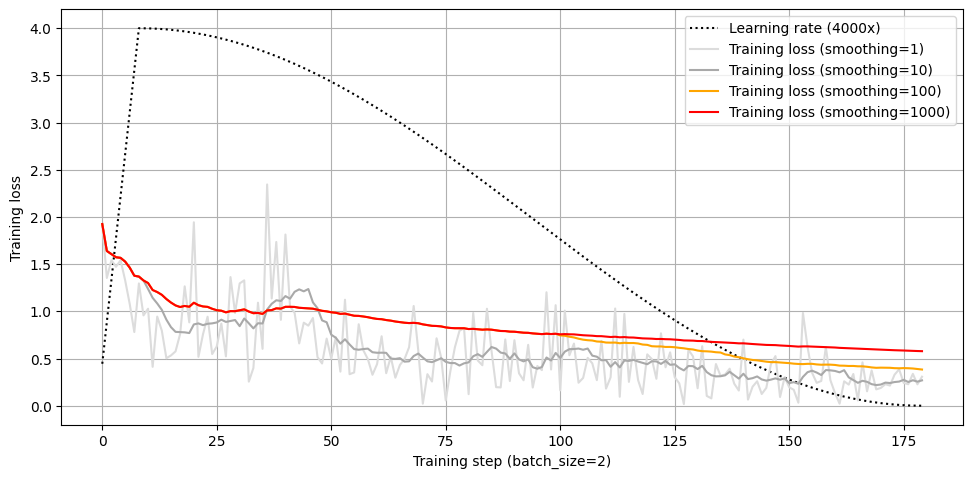

confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-large/split=dev__r=16__bias=all__loradroput=0point2/confusion_matrix_pct.png
confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-large/split=dev__r=16__bias=all__loradroput=0point2/confusion_matrix_abs.png


{'seed': 42,
 'model_id': 'FacebookAI/roberta-large',
 'LoRA_params_dict': {'r': 16,
  'target_modules': ['query',
   'key',
   'value',
   'query_proj',
   'key_proj',
   'value_proj'],
  'bias': 'all',
  'use_rslora': True,
  'task_type': <TaskType.TOKEN_CLS: 'TOKEN_CLS'>,
  'lora_dropout': 0.2},
 'LoraConfig': "LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=16, target_modules={'value', 'key', 'value_proj', 'query_proj', 'query', 'key_proj'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})",
 'LoRA_model_trainable_params': 2639881,
 'LoRA_model_all_params': 356687890,
 'LoRA_model_trainable_fraction': 0.0074,
 'tokenizer': 'F

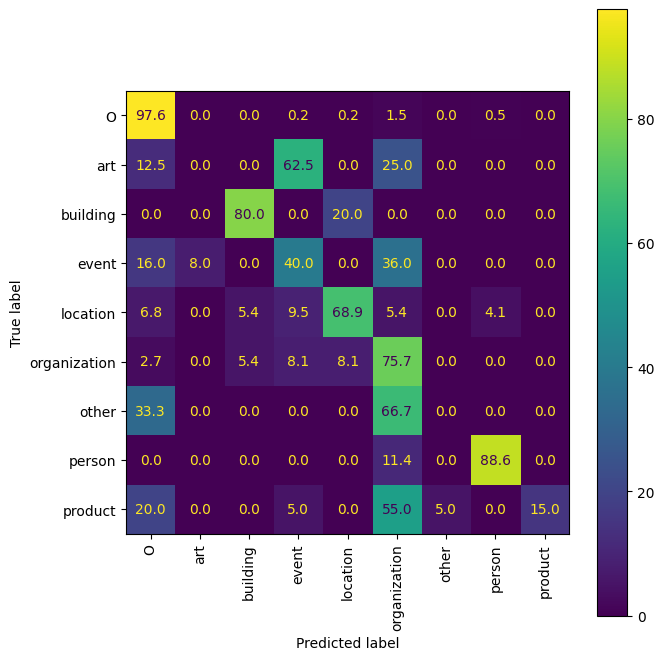

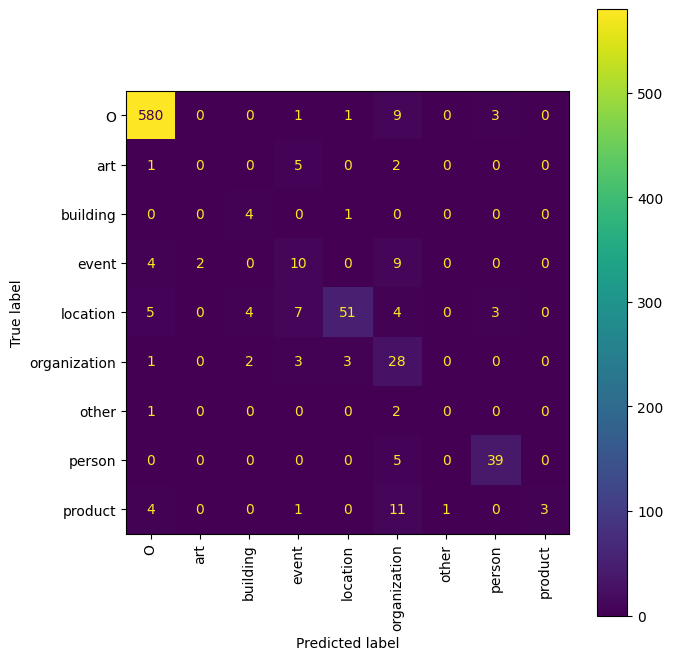

In [8]:
def results(batch_size, lr_rate_list, loss_list, flat_epoch_labels, flat_epoch_predictions):
    # training_loss plot
    ## config
    plt.figure(figsize=(10, 5))
    plt.grid(True)
    plt.tight_layout(pad=2)
    plt.xlabel(f"Training step (batch_size={batch_size})")
    plt.ylabel("Training loss")
    ## learning rate
    lr_factor = 4000
    lr_rate_list_factor = [i*lr_factor for i in lr_rate_list]
    plt.plot(lr_rate_list_factor, linestyle="dotted", color="black", label=f"Learning rate ({lr_factor}x)")
    ## smoothen loss_list and add according line to plot
    colors = ["gainsboro", "darkgray", "orange", "red"]
    for i, smoothing_n in enumerate([1, 10, 100, 1000]):
        smoothened_loss = smoothen_list(loss_list, smoothing_n)
        plt.plot(smoothened_loss, colors[i], label=f"Training loss (smoothing={smoothing_n})")
    ## legend
    plt.legend(loc="upper right", shadow=False)
    ## save and show
    plt.savefig(f"{output_dir}/training_loss_plot.png")
    plt.show()
    # confusion matrices
    flat_epoch_labels_without_special_tokens = []
    flat_epoch_predictions_without_special_tokens = []
    for i in range(len(flat_epoch_labels)):
        label_i = flat_epoch_labels[i]
        prediction_i = flat_epoch_predictions[i]
        if label_i!=-100:
            flat_epoch_labels_without_special_tokens.append(label_i)
            flat_epoch_predictions_without_special_tokens.append(prediction_i)
    ## plot and save confusion matrices
    for percentage in [True, False]:
        make_confusion_matrix(
            flat_epoch_labels_without_special_tokens,
            flat_epoch_predictions_without_special_tokens,
            label_names,
            percentage=percentage,
            output_dir=output_dir
        )
    #
    with open(f"{output_dir}/logs_dict.json", "w") as outfile: 
    	json.dump(logs_dict, outfile, indent=2)
    return logs_dict

results(
    batch_size=batch_size,
    lr_rate_list=lr_rate_list,
    loss_list=loss_list,
    flat_epoch_labels=flat_epoch_labels,
    flat_epoch_predictions=flat_epoch_predictions
)

$\checkmark$